In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, used 1 barriers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compile time = 18.871 ms
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info 

<Axes: >

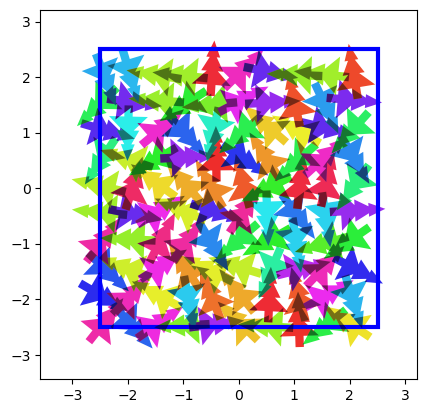

In [2]:
import pack_vis_sol
N_individuals = 200000
xy = cp.meshgrid(cp.arange(10), cp.arange(10))
x = (xy[0].ravel()-5)/2
y = (xy[1].ravel()-5)/2
t = cp.random.default_rng(seed=42).uniform(0, 2*np.pi, size=x.shape[0])
xyt = cp.stack([x, y, t], axis=1)
xyt.shape

sol = kgs.SolutionCollectionSquare()
sol.xyt = cp.tile(xyt, (N_individuals, 1, 1))
sol.xyt[:, :, :] += cp.random.default_rng(seed=43).uniform(0, 0.1, size=(N_individuals, sol.N_trees, 3))
sol.h = cp.tile(cp.array([[5.,0.,0.]], dtype=cp.float32), (N_individuals, 1))
sol.xyt = sol.xyt.astype(cp.float32)
sol.h = sol.h.astype(cp.float32)
sol.check_constraints()

pack_vis_sol.pack_vis_sol(sol)

In [3]:
%%time
cost1 = pack_cost.CollisionCostOverlappingArea().compute_cost_allocate(sol)[0].get()

CPU times: user 2.29 s, sys: 3.59 ms, total: 2.3 s
Wall time: 2.21 s


In [ ]:
import pack_cuda_lut
importlib.reload(pack_cuda_lut)
pack_cuda_lut.USE_TEXTURE = True

# Force reinitialization (picks up code changes including sincosf/floorf fixes)
pack_cuda_lut._initialized = False

# LUT grid dimensions
N_X = 400
N_Y = 400
N_THETA = 400
MAX_R = kgs.tree_max_radius

# Create grid arrays
pack_cuda_lut.LUT_X = np.linspace(-2*MAX_R, 2*MAX_R, N_X)
pack_cuda_lut.LUT_Y = np.linspace(-2*MAX_R, 2*MAX_R, N_Y)
pack_cuda_lut.LUT_theta = np.linspace(-np.pi, np.pi, N_THETA)

# Create meshgrid for all (dx, dy, dtheta) combinations
dx_grid, dy_grid, dt_grid = cp.meshgrid(
    cp.asarray(pack_cuda_lut.LUT_X, dtype=cp.float32),
    cp.asarray(pack_cuda_lut.LUT_Y, dtype=cp.float32),
    cp.asarray(pack_cuda_lut.LUT_theta, dtype=cp.float32),
    indexing='ij'
)

# Flatten to get all combinations
N_individuals = N_X * N_Y * N_THETA
dx_flat = dx_grid.ravel()
dy_flat = dy_grid.ravel()
dt_flat = dt_grid.ravel()

print(f"Building LUT with {N_individuals} grid points ({N_X} x {N_Y} x {N_THETA})")

# Create solution with 2 trees per individual:
# Tree 0: at origin (0, 0, 0)
# Tree 1: at (dx, dy, dtheta)
xyt_lut = cp.zeros((N_individuals, 2, 3), dtype=cp.float32)
xyt_lut[:, 1, 0] = dx_flat  # x of tree 1
xyt_lut[:, 1, 1] = dy_flat  # y of tree 1
xyt_lut[:, 1, 2] = dt_flat  # theta of tree 1

sol_lut = kgs.SolutionCollectionSquare()
sol_lut.xyt = xyt_lut
sol_lut.h = cp.tile(cp.array([[10., 0., 0.]], dtype=cp.float32), (N_individuals, 1))  # large boundary, no clipping
sol_lut.check_constraints()

print(f"Solution shape: xyt={sol_lut.xyt.shape}, h={sol_lut.h.shape}")

# Compute costs using existing cost function
cost_fn = pack_cost.CollisionCostOverlappingArea()
lut_costs, _, _ = cost_fn.compute_cost_allocate(sol_lut)
lut_costs_np = lut_costs.get()

print(f"Cost range: [{lut_costs_np.min():.6f}, {lut_costs_np.max():.6f}]")

# Reshape to LUT grid shape (N_X, N_Y, N_THETA)
pack_cuda_lut.LUT_vals = lut_costs_np.reshape(N_X, N_Y, N_THETA).astype(np.float32)
print(f"LUT_vals shape: {pack_cuda_lut.LUT_vals.shape}")

pack_cuda_lut._ensure_initialized()

Building LUT with 64000000 grid points (400 x 400 x 400)
Solution shape: xyt=(64000000, 2, 3), h=(64000000, 3)


[6.3991547e-04 4.8351288e-04 7.5817108e-05 8.0585480e-04 3.5429001e-04
 9.2506409e-05 4.2676926e-04 2.5510788e-04 1.8596649e-05 5.6934357e-04]


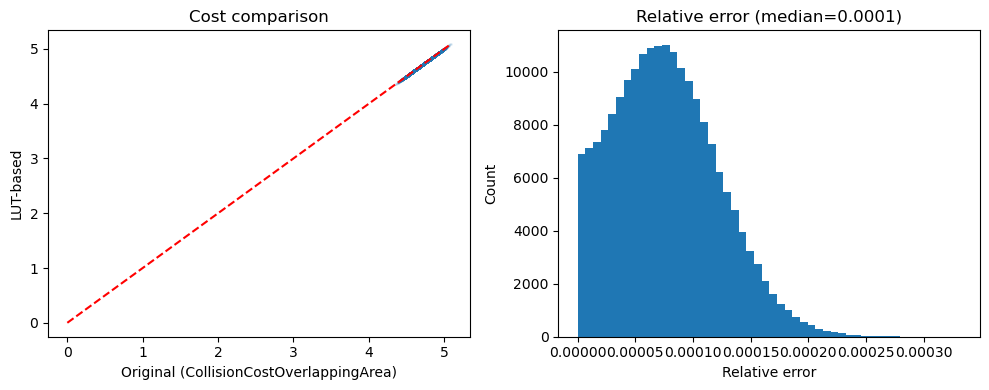

In [ ]:
# Now test LUT-based computation against original
cost2_cp = cp.empty(cost1.shape, dtype=cp.float32)
pack_cuda_lut.overlap_multi_ensemble(sol.xyt, cost2_cp)
cost2 = cost2_cp.get()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(cost1, cost2, alpha=0.1, s=1)
plt.xlabel('Original (CollisionCostOverlappingArea)')
plt.ylabel('LUT-based')
plt.title('Cost comparison')
plt.plot([0, cost1.max()], [0, cost1.max()], 'r--', label='y=x')

plt.subplot(1, 2, 2)
rel_error = np.abs(cost2 - cost1) / (cost1 + 1e-10)
plt.hist(rel_error[cost1 > 0.01], bins=50)
plt.xlabel('Relative error')
plt.ylabel('Count')
plt.title(f'Relative error (median={np.median(rel_error[cost1 > 0.01]):.4f})')
plt.tight_layout()

print((cost2-cost1)[:10])

In [ ]:
# Timing comparison
import time

grad_cp = cp.empty(sol.xyt.shape, dtype=cp.float32)

# Warm up
for _ in range(1):
    pack_cost.CollisionCostSeparation().compute_cost_allocate(sol, evaluate_gradient=True)
    pack_cuda_lut.overlap_multi_ensemble(sol.xyt, cost2_cp, grad_cp)
    cp.cuda.Device().synchronize()

# Time original
n_runs = 3
cp.cuda.Device().synchronize()
t0 = time.perf_counter()
for _ in range(n_runs):
    pack_cost.CollisionCostSeparation().compute_cost_allocate(sol, evaluate_gradient=True)
    cp.cuda.Device().synchronize()
t_orig = (time.perf_counter() - t0) / n_runs

# Time LUT
cp.cuda.Device().synchronize()
t0 = time.perf_counter()
for _ in range(n_runs):
    pack_cuda_lut.overlap_multi_ensemble(sol.xyt, cost2_cp, grad_cp)
    cp.cuda.Device().synchronize()
t_lut = (time.perf_counter() - t0) / n_runs

print(f"Original (CollisionCostOverlappingArea): {t_orig*1000:.2f} ms")
print(f"LUT-based: {t_lut*1000:.2f} ms")
print(f"Speedup: {t_orig/t_lut:.1f}x")

Original (CollisionCostOverlappingArea): 905.72 ms
LUT-based: 53.57 ms
Speedup: 16.9x


In [ ]:
# Test gradient accuracy using finite differences

# Create a smaller test case for gradient checking
np.random.seed(123)
n_trees = 20
n_ensembles = 100

# Random poses - ensure trees can overlap
xyt_test = np.random.uniform(-1, 1, size=(n_ensembles, n_trees, 3)).astype(np.float32)
xyt_test[:, :, 2] = np.random.uniform(-np.pi, np.pi, size=(n_ensembles, n_trees))
xyt_test = cp.asarray(xyt_test)

# Compute cost and gradients
out_cost = cp.zeros(n_ensembles, dtype=cp.float32)
out_grads = cp.zeros((n_ensembles, n_trees, 3), dtype=cp.float32)

pack_cuda_lut.overlap_multi_ensemble(xyt_test, out_cost, out_grads)

# Verify with finite differences
epsilon = 1e-2  # Small enough to stay in same LUT cell
fd_grads = np.zeros((n_ensembles, n_trees, 3), dtype=np.float32)

for dim in range(3):
    for tree_idx in range(n_trees):
        xyt_plus = xyt_test.copy()
        xyt_minus = xyt_test.copy()
        xyt_plus[:, tree_idx, dim] += epsilon
        xyt_minus[:, tree_idx, dim] -= epsilon
        
        cost_plus = cp.zeros(n_ensembles, dtype=cp.float32)
        cost_minus = cp.zeros(n_ensembles, dtype=cp.float32)
        pack_cuda_lut.overlap_multi_ensemble(xyt_plus, cost_plus)
        pack_cuda_lut.overlap_multi_ensemble(xyt_minus, cost_minus)
        
        fd_grads[:, tree_idx, dim] = ((cost_plus - cost_minus) / (2 * epsilon)).get()

# Compare
analytical_grads = out_grads.get()
abs_error = np.abs(analytical_grads - fd_grads)

# Only check where gradients are non-negligible
mask = np.abs(fd_grads) > 0.01
rel_error = np.zeros_like(abs_error)
rel_error[mask] = abs_error[mask] / np.abs(fd_grads[mask])

print(f"=== Gradient Accuracy Test ===")
print(f"Max absolute error: {abs_error.max():.2e}")
print(f"Mean absolute error: {abs_error.mean():.2e}")
print(f"Max relative error (where |fd| > 0.01): {rel_error[mask].max():.2e}")
print(f"Mean relative error (where |fd| > 0.01): {rel_error[mask].mean():.2e}")

# Check for any large relative errors (>5%)
large_errors = rel_error > 0.05
if large_errors.any():
    print(f"\nWARNING: {large_errors.sum()} gradient values have relative error > 5%")
    idx = np.unravel_index(rel_error.argmax(), rel_error.shape)
    print(f"Worst case at ensemble={idx[0]}, tree={idx[1]}, dim={idx[2]}")
    print(f"  Analytical: {analytical_grads[idx]:.6f}")
    print(f"  Finite diff: {fd_grads[idx]:.6f}")
else:
    print("\n✓ All gradients match within 5% tolerance!")

=== Gradient Accuracy Test ===
Max absolute error: 7.89e-02
Mean absolute error: 6.31e-03
Max relative error (where |fd| > 0.01): 2.01e+00
Mean relative error (where |fd| > 0.01): 5.45e-02

Worst case at ensemble=55, tree=1, dim=0
  Analytical: 0.014299
  Finite diff: -0.014180


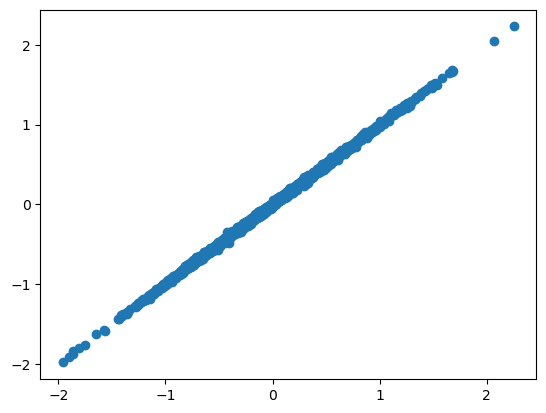

In [ ]:
plt.scatter(analytical_grads, fd_grads)

In [ ]:
# Now test with 2-tree case
np.random.seed(42)
n_trees = 2
n_ensembles = 10

xyt_2 = np.zeros((n_ensembles, n_trees, 3), dtype=np.float32)
xyt_2[:, 0, :] = [0, 0, 0.3]  # Non-zero theta for ref
xyt_2[:, 1, 0] = 0.2
xyt_2[:, 1, 1] = 0.15  
xyt_2[:, 1, 2] = 0.5
xyt_2 = cp.asarray(xyt_2)

# Compute gradients
out_cost = cp.zeros(n_ensembles, dtype=cp.float32)
out_grads = cp.zeros((n_ensembles, n_trees, 3), dtype=cp.float32)
pack_cuda_lut.overlap_multi_ensemble(xyt_2, out_cost, out_grads)

print("CUDA output:")
print(f"  Cost: {out_cost[0].get():.6f}")
print(f"  Grad tree 0: {out_grads[0, 0].get()}")
print(f"  Grad tree 1: {out_grads[0, 1].get()}")

# FD check
epsilon = 1e-3
for tree_idx in range(2):
    for dim in range(3):
        xyt_plus = xyt_2.copy()
        xyt_minus = xyt_2.copy()
        xyt_plus[:, tree_idx, dim] += epsilon
        xyt_minus[:, tree_idx, dim] -= epsilon
        
        cost_plus = cp.zeros(n_ensembles, dtype=cp.float32)
        cost_minus = cp.zeros(n_ensembles, dtype=cp.float32)
        pack_cuda_lut.overlap_multi_ensemble(xyt_plus, cost_plus)
        pack_cuda_lut.overlap_multi_ensemble(xyt_minus, cost_minus)
        
        fd_grad = ((cost_plus[0] - cost_minus[0]) / (2 * epsilon)).get()
        ana_grad = out_grads[0, tree_idx, dim].get()
        
        dim_name = ['x', 'y', 'theta'][dim]
        ratio = ana_grad / fd_grad if abs(fd_grad) > 1e-10 else 0
        print(f"Tree {tree_idx}, {dim_name}: FD={fd_grad:.6f}, Ana={ana_grad:.6f}, Ratio={ratio:.4f}")

CUDA output:
  Cost: 0.058092
  Grad tree 0: [ 0.48189425  0.30618632 -0.01916256]
  Grad tree 1: [-0.48189425 -0.30618632  0.00811569]
Tree 0, x: FD=0.490580, Ana=0.481894, Ratio=0.9823
Tree 0, y: FD=0.306597, Ana=0.306186, Ratio=0.9987
Tree 0, theta: FD=-0.020873, Ana=-0.019163, Ratio=0.9181
Tree 1, x: FD=-0.490580, Ana=-0.481894, Ratio=0.9823
Tree 1, y: FD=-0.306597, Ana=-0.306186, Ratio=0.9987
Tree 1, theta: FD=0.005528, Ana=0.008116, Ratio=1.4680
